In [108]:
from spectral import *
import spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import spectral as spy
from scipy.integrate import cumtrapz
from numpy import linalg as LA

img = spectral.open_image('D1_F12_H1_Cropped.hdr')
header ="C:/Users/Yaniv/PycharmProjects/project_stanley/D1_F12_H1_Cropped.hdr"
data = open_image(header)
my_cube = data.load().copy()

In [109]:
def visual(data, name,bands):  # Visualize the cube
    # Choose four different bands to display
    data = (255 / np.max(data.flatten())) * data
    bands = [bands[0], bands[1], bands[2], bands[3]]
    # Create a figure with subplots to display the band images
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    # Display each band image in a subplot
    for band, ax in zip(bands, axes.flat):
        band_image = data[:, :, band]
        ax.imshow(band_image, cmap='gray')
        ax.set_title('Band {}'.format(band))
    plt.suptitle("{}".format(name))
    plt.show()
# bands = [1, 2, 3, 120]
# visual(my_cube, "Data",bands)

In [110]:
M = np.zeros(np.shape(my_cube))
for i in range(M.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(my_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(my_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M[:, :, i] = neighbor_sum / (neighbor_count - 1)
X_MINUS_M = np.subtract(my_cube, M)

arg_cov_n = X_MINUS_M.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_n = np.cov(arg_cov_n.transpose())  #Transpose- Python vs. Matlab get_cov8(cube, get_m8(cube))

In [111]:
eigenvalues_n, eigenvectors_n = np.linalg.eig(phi_n)
sorted_indices = np.argsort(eigenvalues_n)[::-1]
sorted_eigenvalues_n = eigenvalues_n[sorted_indices]
sorted_eigenvectors_n = eigenvectors_n[:, sorted_indices]
eignvalues_mat_n = np.diag(np.power(eigenvalues_n,-0.5))

arg_cov_s = M.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_s = np.cov(arg_cov_n.transpose())  #Transpose- Python vs. Matlab
eigenvalues_s, eigenvectors_s = np.linalg.eig(phi_n)
sorted_indices = np.argsort(eigenvalues_s)[::-1]
sorted_eigenvalues_s = eigenvalues_s[sorted_indices]
sorted_eigenvectors_s = eigenvectors_s[:, sorted_indices] #(511, 511)


cube_new_yaniv = np.zeros(np.shape(my_cube))
my_matrix = eignvalues_mat_n@sorted_eigenvectors_n.T#sorted_eigenvectors_s.T@eignvalues_mat_n@sorted_eigenvectors_n.T
for i in range(np.shape(my_cube)[0]):
    for j in range(np.shape(my_cube)[1]):
        cube_new_yaniv[i,j,:] = my_matrix@my_cube[i,j,:]

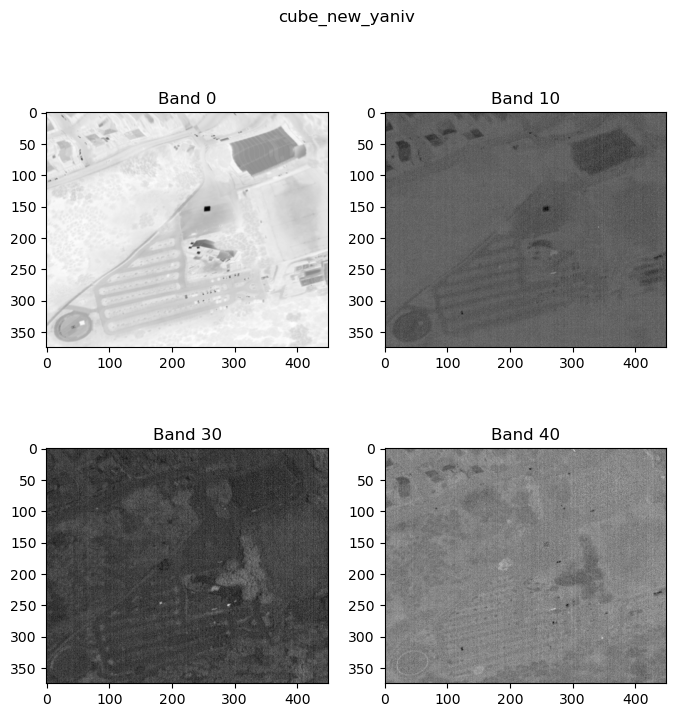

In [112]:
bands = [0,10,30,40]
visual(cube_new_yaniv, "cube_new_yaniv",bands)

Part 2:

In [86]:
# X_MINUS_M = np.subtract(cube, M)
# arg_cov = X_MINUS_M.reshape(img.shape[0] * img.shape[1], img.shape[2])
# phi = np.cov(arg_cov.transpose())  # Transpose- Python vs. Matlab
# t_inv_phi = np.dot(t, LA.inv(phi))
# MF_NT = np.zeros((img.shape[0], img.shape[1]))
# MF_WT = np.zeros((img.shape[0], img.shape[1]))
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         MF_NT[i, j] = np.dot(t_inv_phi, (cube[i, j, :] - M[i, j, :]))
#         MF_WT[i, j] = np.dot(t_inv_phi, (cube[i, j, :] - M[i, j, :] + p * t))
#
# NT_val, NT_bins = np.histogram(MF_NT, bins=100)
# WT_val, WT_bins = np.histogram(MF_WT, bins=100)
# fig, ax = plt.subplots()
# ax.plot(NT_bins[:-1], NT_val, label='No target')
# ax.plot(WT_bins[:-1], WT_val, label='With target')
# ax.set(title='Original Histogram', xlabel='Bins', ylabel='Frequency')
# ax.legend()
# plt.show()
#
# Pd = 1 - (np.cumsum(WT_val) / np.sum(
#     WT_val))  # 1-((cumtrapz(WT_val, WT_bins[:-1]))/(cumtrapz(WT_val, WT_bins[:-1])[-1]))
# Pfa = 1 - (np.cumsum(NT_val) / np.sum(
#     NT_val))  # 1-((cumtrapz(NT_val, NT_bins[:-1]))/(cumtrapz(NT_val, NT_bins[:-1])[-1]))
#
# plt.plot(WT_bins[:-1], Pd, label="Pd")
# plt.plot(NT_bins[:-1], Pfa, label="Pfa")
# plt.xlabel('bins')
# plt.ylabel('Cumulative Probability')
# plt.title('Inverse Cumulative Probability distribution')
# plt.legend()
# plt.show()
#
# th = 0.1
# index = max(100 - np.argmax(WT_bins > NT_bins[-1]), np.argmax(NT_bins > WT_bins[0]))
# Pd_new = np.pad(Pd, (index, 0), mode='constant', constant_values=(1, 1))
# Pfa_new = np.pad(Pfa, (0, index), mode='constant', constant_values=(0, 0))
#
# plt.plot(Pfa_new, Pd_new)
# plt.plot([0, th], [0, th], '--')
# plt.title('ROC Curve')
# plt.xlim(0, th)
# plt.show()
#
# Pd_new = np.flip(Pd_new)
# Pfa_new = np.flip(Pfa_new)
#
#
# def area(th):
#     cond = np.where(Pfa_new > th)[0][0]
#     Pd_mask = Pd_new.copy()
#     Pd_mask[cond:] = 0
#     A = cumtrapz(Pd_mask, Pfa_new)
#     return (A - 0.5 * pow(th, 2)) / (th - 0.5 * pow(th, 2))
#
#
# print("Performance, using 'area test':")
# print("th= 0.001:", area(0.001)[-1])
# print("th= 0.01:", area(0.01)[-1])
# print("th= 0.1:", area(0.1)[-1])